# 文本切分可视化
除了用于RAG（如问答系统）外，分块还可以应用在帮助理解复杂文档的场景中。比如，当我们面对一本书或一篇长篇文章时，分块可以将其按内容和语义分成多个小组，每组代表一个主要概念，然后对每个组进行简要总结。这种方法能有效帮助我们快速获得文档的核心内容，而无需逐字阅读。

- `字符分块`（Character-based Chunking）
  
  最简单的分块方式，我们可以选择一个固定的字符窗口，将文本按该长度拆分成多个片段。我们可以在片段之间添加一些重叠区，以保持文本的顺序关系。尽管这种方法计算简单，但生成的片段不一定具备语义完整性，甚至可能打断句子的完整性。
- `递归分块`
  
  在应用中通常更加实用。递归分块会使用一系列层次化的分隔符（LangChain的默认分隔符列表是 **[“\n\n”, “\n”, “ ”, “”]** ）和目标长度，将文本递归地拆分。这种方式更能保持段落和句子的完整性，因此生成的分块通常更连贯。但它不考虑语义关联，如果一个句子恰好位于分块窗口的边界，可能会将内容相关的句子分隔开来。`
- `语义分块`
 
  语义分块则依靠嵌入向量的相似性来分段，使每个片段在内容上更具独立性。

  - 阈值如何选取？
  - 递归的阈值切分
  - 如何判断语义切分是否合理？

In [1]:
from langchain_community.embeddings import HuggingFaceEmbeddings
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot  as plt
from typing import List

## 文本分块

In [2]:
with open('water.txt') as file:
    essay = file.read()
    
import re

# Splitting the essay on '。', '？', and '!'
single_sentences_list = re.split(r'(?<=[。？！；])\s*(?=\S)', essay)

## 计算句子的属性（分块数量、字符长度）

In [3]:
def cal_desc(sentences):
    max_len = 0
    min_len = float("inf")
    lsplits = len(sentences)
    sum_len = 0
    for text in sentences:
        lt = len(text)
        sum_len += lt
        max_len = max(max_len, lt)
        min_len = min(min_len, lt)
    mean_len = sum_len / lsplits
    print(
        "Creating {} chunks\nMean len: {}\nMax len: {}\nMin len: {}".format(
            lsplits, mean_len, max_len, min_len
        )
    )

In [4]:
cal_desc(single_sentences_list)

Creating 59 chunks
Mean len: 63.355932203389834
Max len: 146
Min len: 15


In [5]:
single_sentences_list

['全球水资源状况\n随着人类社会的进步和经济的发展，工业、农业、城市的日益扩展，特别是世界人口急剧增多，加之，人类活动失控，造成环境恶化，水资源污染及严重浪费，迫使世界水资源日趋匮缺。',
 '据材料统计：20世纪初，全球水消耗量为5000亿m3/y，到世纪末已增长为50000亿m3/y(增长10倍以上)1954年-1994年美洲大陆用水增加100%，非洲大陆用水量增加300%以上，欧洲大陆增加500%，而亚洲大陆增长幅度更高。',
 '地下水之开采量为5500亿m3/y(80-90年代)，其中大于100亿m3/y的有10余个国家，占总开采量的8.5%。',
 '2001年3月在海牙召开的“第二届世界水资源论坛”部长级会议上，21世纪世界水事委员会报告说，目前全球有10-11亿人没有用上洁净水，有21亿人没有良好的卫生设备，随着世界人口的不断增加，今后20-25年，人类用水量将增加40%左右，世界将面临水资源的严重危机；',
 '报告中还强调指出，地球上只有2.5%的水是淡水，而其中2/3存在于冰盖和冰川中，无法直接利用，仅剩的那一小部分水资源，大约有20%在人迹罕至的地区，其余80%的水则通过季风、暴风雨以及洪水等形式，在错误的时间降落到错误的地点，供给人类直接利用的水资源确实有限，仅为1%左右；',
 '报告中说，到2025年世界新增30亿人口，所需供水缺少20%，加之浪费与污染可达50%以上；',
 '据“平衡与人口协会”估计，20-30年内缺水人口可达15-20亿人。',
 '据联合国教科文组织统计资料，按全世界人口为50-60亿计算，人均占有水量约为8000-10000吨。',
 '1997年“第一届世界水论坛”报告说，由于世界水资源消费量急剧增加6倍，远远超过4000km3,人均淡水占有量已降到4800m3，(1995年为7300m3)。',
 '由于仅有的淡水量分布不平衡，有60%-65%以上的淡水集中分布在9-10个国家，例如俄罗斯、美国、加拿大、印度尼西亚、哥伦比亚等，其中奥地利每年有840亿吨水可满足欧盟3.7亿人口的用水需求，供水收入达10亿欧元。',
 '而占世界人口总量40%的80多个国家却为水资源匮乏的国家，其中有近30个国家为严重缺水国，非洲占有19个，像卡塔尔仅有91m3，科威特为95m3，利比亚为111m3，马尔他为82m3，成为

## 加载语义分块的**Embedding Model**
- 对单句进行embedding编码

In [6]:
# Embedding model
model_name = "moka-ai/m3e-base"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

sentences_embed= embeddings.embed_documents(single_sentences_list)

/home/blackink/anaconda3/envs/langchain/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/home/blackink/anaconda3/envs/langchain/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/blackink/anaconda3/envs/langchain/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downlo

## 计算相邻文本的语义余弦距离

In [7]:
def cosine_similarity_embed(sentences_embed) -> np.ndarray:
    """
    Calculates the cosine distances between consecutive text chunk embeddings.

    Returns:
        np.ndarray: An array of cosine distances between consecutive embeddings.
    """
    len_embeddings = len(sentences_embed)
    cdists = np.empty(len_embeddings - 1)

    for i in range(1, len_embeddings):
        cdists[i - 1] = cosine(
            sentences_embed[i], sentences_embed[i - 1]
        )

    return cdists

In [8]:
distances = cosine_similarity_embed(sentences_embed)

In [9]:
distances

array([0.13526252, 0.10381331, 0.17837591, 0.11926713, 0.1005566 ,
       0.10561324, 0.14139482, 0.1323342 , 0.12568271, 0.09780948,
       0.07624078, 0.16607946, 0.1860186 , 0.10687701, 0.09282845,
       0.14633243, 0.15058099, 0.20390683, 0.15665116, 0.2097834 ,
       0.22070057, 0.22449421, 0.20526444, 0.29590044, 0.1589673 ,
       0.14451656, 0.15971241, 0.18016549, 0.14428395, 0.12792719,
       0.0999858 , 0.1810411 , 0.23243944, 0.15412291, 0.15380187,
       0.13415157, 0.15149729, 0.19936526, 0.1321741 , 0.24671302,
       0.24937357, 0.27882546, 0.12790233, 0.14388918, 0.12183607,
       0.18301794, 0.09759145, 0.10581889, 0.17766448, 0.18600747,
       0.1950299 , 0.17278125, 0.19223847, 0.19160872, 0.09954933,
       0.11084873, 0.08539038, 0.13745258])

## 根据阈值进行可视化

- 调整阈值的大小确定不同的语义切割点。

In [10]:
def plot_chunk_and_breakpoints(distances:List[np.ndarray] = None , breakpoint_percentile_threshold:int=95 , plot: bool = True):
     
    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)
    # 找到所有超过阈值的点的索引位置
    threshold_indices = np.argwhere(distances >= breakpoint_distance_threshold).ravel()
    if plot:
        plt.figure(figsize=(12, 4))  
        # 绘制所有超过阈值的点的垂直线
        plt.plot(distances, "rx", markersize=5)  # 标记所有距离点
        for index in threshold_indices:
            plt.axvline(x=index, color='r', linestyle='--')  # 在每个超过阈值的点上画垂直线

        plt.plot(distances)  
        plt.xlabel("Index")
        plt.ylabel("Distance")
        plt.title(f"Distances with {breakpoint_percentile_threshold}th Percentile Threshold Lines")

        plt.show()
    
    return threshold_indices


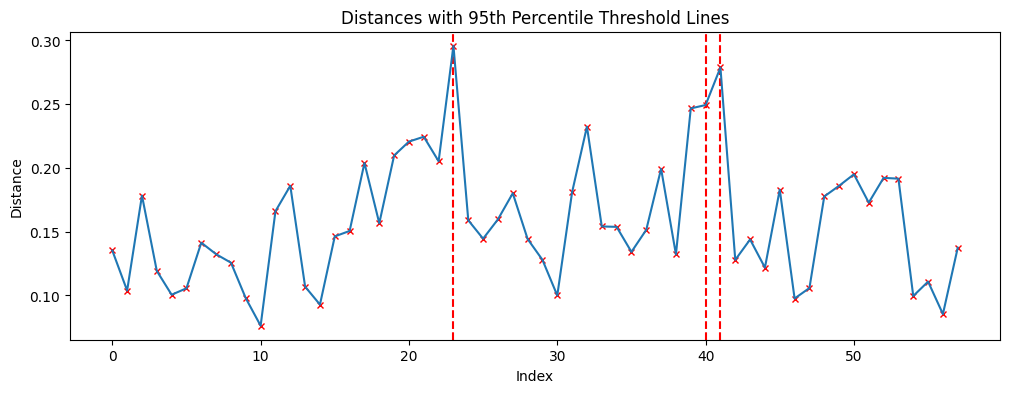

array([23, 40, 41])

In [11]:
plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=95)

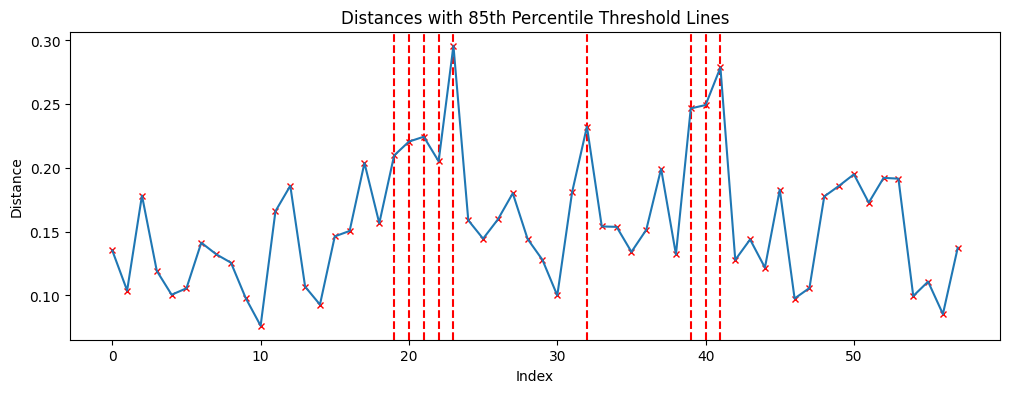

array([19, 20, 21, 22, 23, 32, 39, 40, 41])

In [12]:
plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=85)

In [13]:
def build_semantic_groups(split_texts , breakpoints: List[int]) -> List[str]:
    """
    Constructs semantic groups from text splits using specified breakpoints.

    Args:
        breakpoints (List[int]): A list of indices representing breakpoints.

    Returns:
        List[str]: A list of concatenated text strings for each semantic group.
    """
    start_index = 0
    grouped_texts = []
    # add end criteria
    breakpoints = np.append(breakpoints, [-1])
    for break_point in breakpoints:
        # we're at the end of the text
        if break_point == -1:
            grouped_texts.append(
                " ".join([x for x in split_texts[start_index:]])
            )

        else:
            grouped_texts.append(
                " ".join([x for x in split_texts[start_index : break_point + 1]])
            )

        start_index = break_point + 1

    return grouped_texts

In [14]:
build_semantic_groups(single_sentences_list , plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=95,plot=False))

['全球水资源状况\n随着人类社会的进步和经济的发展，工业、农业、城市的日益扩展，特别是世界人口急剧增多，加之，人类活动失控，造成环境恶化，水资源污染及严重浪费，迫使世界水资源日趋匮缺。 据材料统计：20世纪初，全球水消耗量为5000亿m3/y，到世纪末已增长为50000亿m3/y(增长10倍以上)1954年-1994年美洲大陆用水增加100%，非洲大陆用水量增加300%以上，欧洲大陆增加500%，而亚洲大陆增长幅度更高。 地下水之开采量为5500亿m3/y(80-90年代)，其中大于100亿m3/y的有10余个国家，占总开采量的8.5%。 2001年3月在海牙召开的“第二届世界水资源论坛”部长级会议上，21世纪世界水事委员会报告说，目前全球有10-11亿人没有用上洁净水，有21亿人没有良好的卫生设备，随着世界人口的不断增加，今后20-25年，人类用水量将增加40%左右，世界将面临水资源的严重危机； 报告中还强调指出，地球上只有2.5%的水是淡水，而其中2/3存在于冰盖和冰川中，无法直接利用，仅剩的那一小部分水资源，大约有20%在人迹罕至的地区，其余80%的水则通过季风、暴风雨以及洪水等形式，在错误的时间降落到错误的地点，供给人类直接利用的水资源确实有限，仅为1%左右； 报告中说，到2025年世界新增30亿人口，所需供水缺少20%，加之浪费与污染可达50%以上； 据“平衡与人口协会”估计，20-30年内缺水人口可达15-20亿人。 据联合国教科文组织统计资料，按全世界人口为50-60亿计算，人均占有水量约为8000-10000吨。 1997年“第一届世界水论坛”报告说，由于世界水资源消费量急剧增加6倍，远远超过4000km3,人均淡水占有量已降到4800m3，(1995年为7300m3)。 由于仅有的淡水量分布不平衡，有60%-65%以上的淡水集中分布在9-10个国家，例如俄罗斯、美国、加拿大、印度尼西亚、哥伦比亚等，其中奥地利每年有840亿吨水可满足欧盟3.7亿人口的用水需求，供水收入达10亿欧元。 而占世界人口总量40%的80多个国家却为水资源匮乏的国家，其中有近30个国家为严重缺水国，非洲占有19个，像卡塔尔仅有91m3，科威特为95m3，利比亚为111m3，马尔他为82m3，成为世界上四大缺水国； 而几个富水国，水资源消费急剧上升，像美国纽约人均日耗水量为6

##  递归语义切分

与仅仅改变百分位数阈值相比，另一种方法是递归地应用相同的阈值。我们首先在整个文本上创建断点。然后，对于每个新创建的文本块，如果其长度超过某个阈值，就在该文本块内部再次创建断点。这个过程会持续进行，直到所有文本块的长度都低于阈值。

In [15]:
def build_chunks_stack(
    distances, length_threshold: int = 500, cosine_distance_percentile_threshold: int = 95
) -> np.ndarray:
    
    S = [(0, len(distances))]
    all_breakpoints = set()
    while S:
        id_start, id_end = S.pop()
        distance = distances[id_start:id_end]
        updated_breakpoints = plot_chunk_and_breakpoints(
            distance,
            breakpoint_percentile_threshold=cosine_distance_percentile_threshold,
            plot = False
            
        )
        if updated_breakpoints.size == 0:
            continue  
        updated_breakpoints += id_start
        updated_breakpoints = np.concatenate(
            (np.array([id_start - 1]), updated_breakpoints, np.array([id_end]))
        )
        for index in updated_breakpoints:
            text_group = single_sentences_list[id_start : index + 1]
            total_text = sum(len(text) for text in text_group)
            if (len(text_group) > 2) and (
                total_text >= length_threshold
            ):
                S.append((id_start, index))
            id_start = index + 1
        all_breakpoints.update(updated_breakpoints)

    return np.array(sorted(all_breakpoints))[1:-1]

In [16]:
build_chunks_stack(distances)

array([ 2,  6, 11, 12, 17, 19, 20, 21, 23, 31, 32, 39, 40, 41, 50, 52])

In [17]:
sem_split = build_semantic_groups(single_sentences_list , build_chunks_stack(distances))

In [19]:
cal_desc(sem_split)


Creating 17 chunks
Mean len: 222.35294117647058
Max len: 494
Min len: 20


In [20]:
def plot_chunk_differences_and_breakpoints(
        split_texts: List[str],
        break_points: np.ndarray,
        chunk_cosine_distances: np.ndarray,
    ) -> None:
        """
        Plots the differences and breakpoints of text chunks based on cosine distances.

        Args:
            split_texts (List[str]): A list of text splits.
            break_points (np.ndarray): An array of break point indices.
            chunk_cosine_distances (np.ndarray): An array of cosine distances between text splits.

        Returns:
            None
        """
        cumulative_len = np.cumsum([len(x) for x in split_texts])
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot(111)

        cosine_dist_min = 0
        cosine_dist_max = 1.1 * max(chunk_cosine_distances)

        ax.plot(cumulative_len[:-1], chunk_cosine_distances)
        ax.plot(cumulative_len[:-1], chunk_cosine_distances, "rx", markersize=5)
        ax.vlines(
            cumulative_len[break_points],
            ymin=cosine_dist_min,
            ymax=cosine_dist_max,
            colors="r",
            linestyles="--",
        )

        ax.set_xlabel("Cumulative characters")
        ax.set_ylabel("Cosine distance between splits")

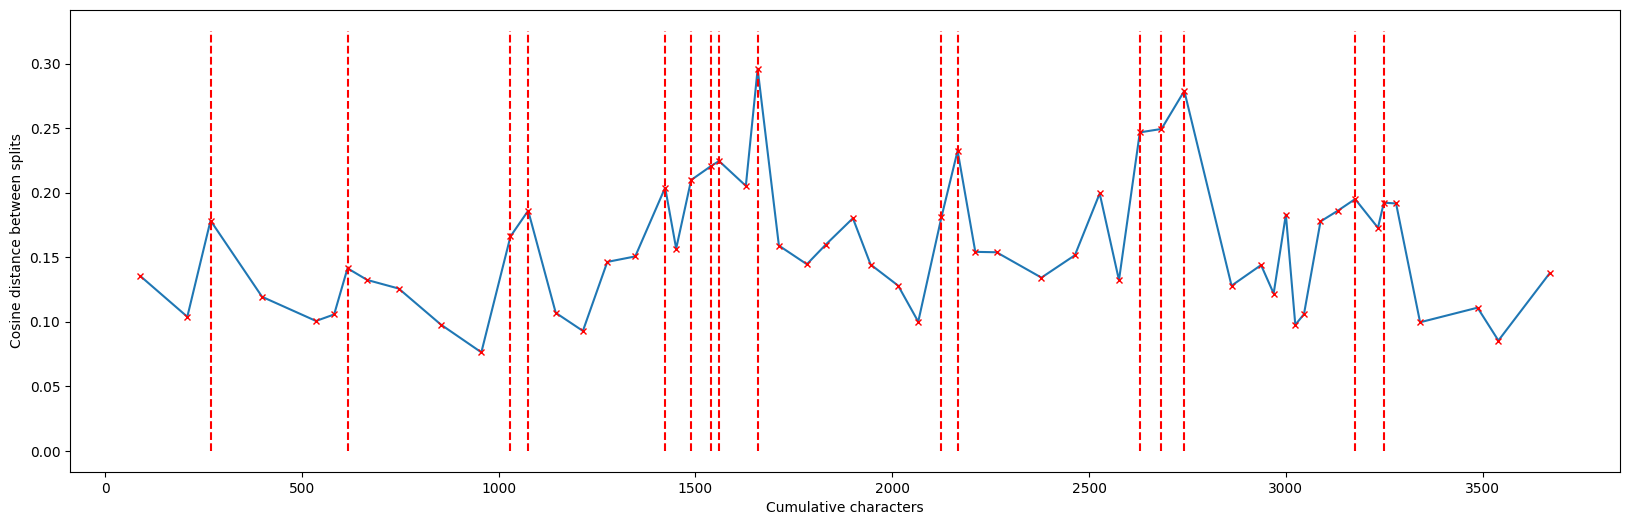

In [21]:
plot_chunk_differences_and_breakpoints(single_sentences_list , build_chunks_stack(distances) , distances)

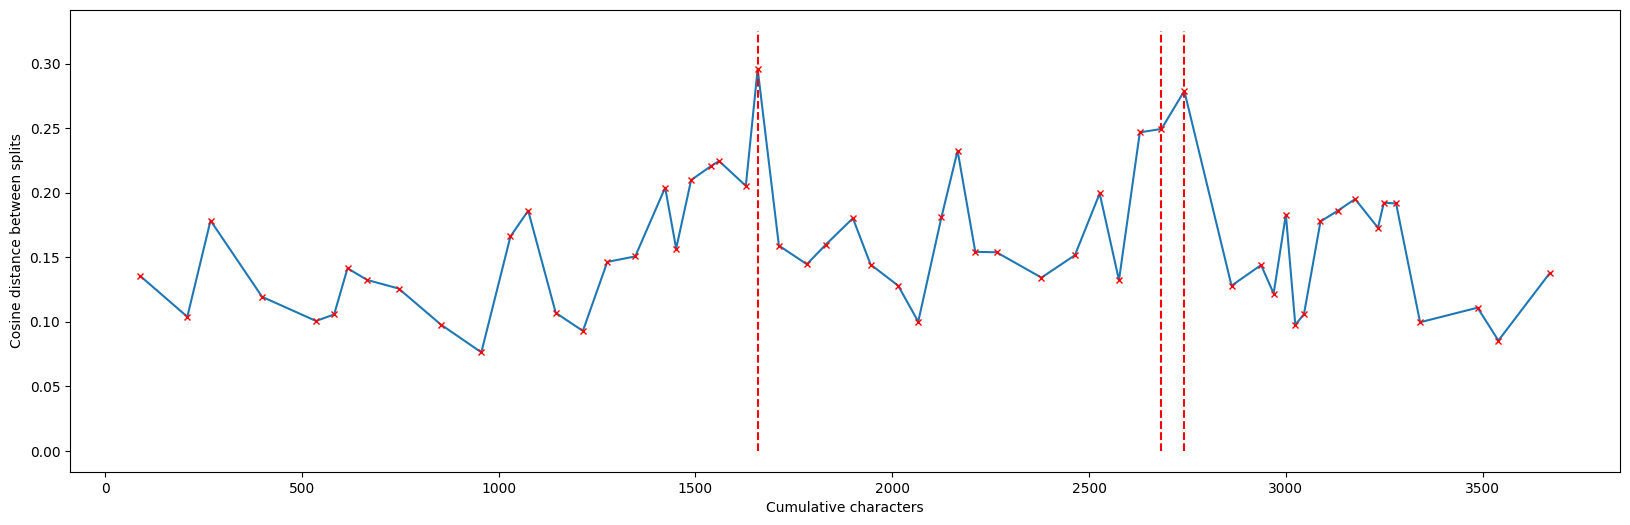

In [22]:
plot_chunk_differences_and_breakpoints(single_sentences_list , plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=95 ,plot=False) , distances)

## 如何衡量语义切分是否合理 （可视化）
 - TSNE (降维)
 - Kmeans （聚类）
 - 连线


In [23]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

tsne = TSNE(n_components=2 ,  perplexity=5 ,random_state=24)
sentences_embed_np = np.array(sentences_embed)
embeddings_2d = tsne.fit_transform(sentences_embed_np )

## 获取聚类类别

In [24]:
breakpoint_95_rec = build_chunks_stack(distances)
updated_breakpoints = np.concatenate(
            (np.array([-1]), breakpoint_95_rec, np.array([len(distances)]))
        )

cdists = np.empty(len(distances) +1 )
for i in range(1,len(updated_breakpoints)):
    cdists[updated_breakpoints[i-1]+1:updated_breakpoints[i]+1] = i-1

In [25]:
cdists

array([ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  3.,
        4.,  4.,  4.,  4.,  4.,  5.,  5.,  6.,  7.,  8.,  8.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9., 10., 11., 11., 11., 11., 11., 11.,
       11., 12., 13., 14., 14., 14., 14., 14., 14., 14., 14., 14., 15.,
       15., 16., 16., 16., 16., 16., 16.])

In [26]:
def clusetr_sentences_plt(n_clusters , cdists):
    """
        Plots the distribution and breakpoints of text chunks based on cosine distances.

        Args:
            n_clusters (int): Total number of clusters (categories) for classification.
            cdists (np.ndarray): An array of indices representing cluster points.
        
        Returns:
            None
    """
    # 使用K-means进行聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=24)
    y_kmeans = kmeans.fit_predict(embeddings_2d)

    plt.figure(figsize=(15, 10))
    
    colors = sns.color_palette( 'hsv', n_clusters)

    # 绘制每个聚类
    for i in range(n_clusters):
        # 选择当前聚类的所有点
        cluster_points = embeddings_2d[cdists == i]
        
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=colors[i], 
                    label=f'Cluster {i+1}', 
                    s=50, 
                    alpha=0.7)
        
        # 如果聚类中点数大于1，则连接点
        if len(cluster_points) > 1:
            # 按第一个维度排序
            sorted_indices = np.argsort(cluster_points[:, 0])
            sorted_cluster_points = cluster_points[sorted_indices]
            
            plt.plot(sorted_cluster_points[:, 0], 
                    sorted_cluster_points[:, 1], 
                    color=colors[i], 
                    linestyle='-', 
                    linewidth=1, 
                    alpha=0.5)
    # 绘制聚类中心
    centers = kmeans.cluster_centers_
    for center in centers:
        plt.plot(center[0], center[1], 
                marker='x', 
                markersize=20, 
                color='red', 
                markeredgewidth=3 ,
                alpha=0.35)

    plt.title(f'K-means Clustering with t-SNE (k={n_clusters})', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)

    # 添加图例，分两列显示
    plt.legend(bbox_to_anchor=(1.05, 1), 
            loc='upper left', 
            borderaxespad=0.,
            ncol=2)

    # 调整布局以显示完整图例
    plt.tight_layout()

    plt.show()

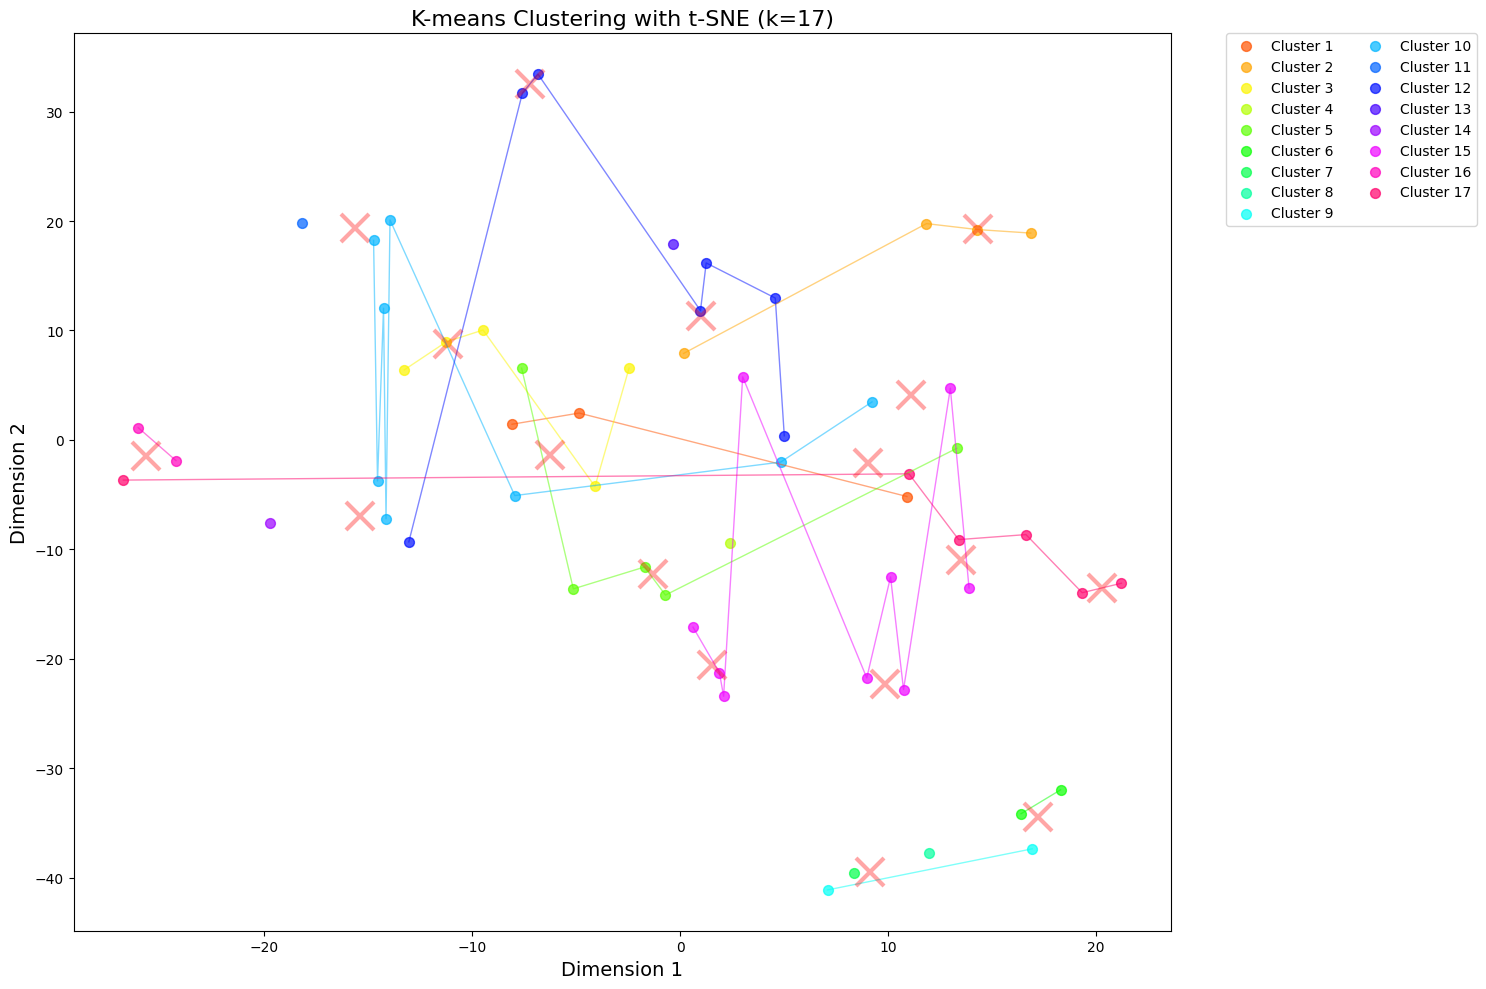

In [27]:
clusetr_sentences_plt(17 , cdists)